# NB07: Question-Level Error Analysis

**Question:** What do models get wrong? Are there systematic error patterns?

This notebook goes beyond aggregate metrics to inspect individual predictions:
1. **Question difficulty spectrum** — easy / discriminating / hard
2. **Error taxonomy** — classifying wrong answers
3. **Answer length analysis** — does verbosity correlate with quality?
4. **Model agreement** — do models agree on which questions are hard?

In [1]:
print(1)

1


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from analysis_utils import (
    load_all_results, setup_plotting,
    load_per_item_scores, compute_question_difficulty,
    sample_predictions_with_docs,
    PRIMARY_METRIC, BROKEN_MODELS, MODEL_TIER,
)

setup_plotting()
STUDY_PATH = Path("../outputs/smart_retrieval_slm")

# Load per-item scores with text
print("Loading per-item scores (this may take a minute)...")
item_scores = load_per_item_scores(STUDY_PATH, metric=PRIMARY_METRIC, include_text=True)
item_scores = item_scores[~item_scores['model_short'].isin(BROKEN_MODELS)].copy()
print(f"Loaded {len(item_scores)} per-item scores")
print(f"  Experiments: {item_scores['experiment'].nunique()}")
print(f"  Unique questions: {item_scores['idx'].nunique()}")

Loading per-item scores (this may take a minute)...
Loaded 948000 per-item scores
  Experiments: 948
  Unique questions: 1000


## 1. Question Difficulty Spectrum

Questions analyzed: 3000

Difficulty distribution:
  easy           :    0 (0.0%)
  discriminating : 1391 (46.4%)
  hard           : 1609 (53.6%)


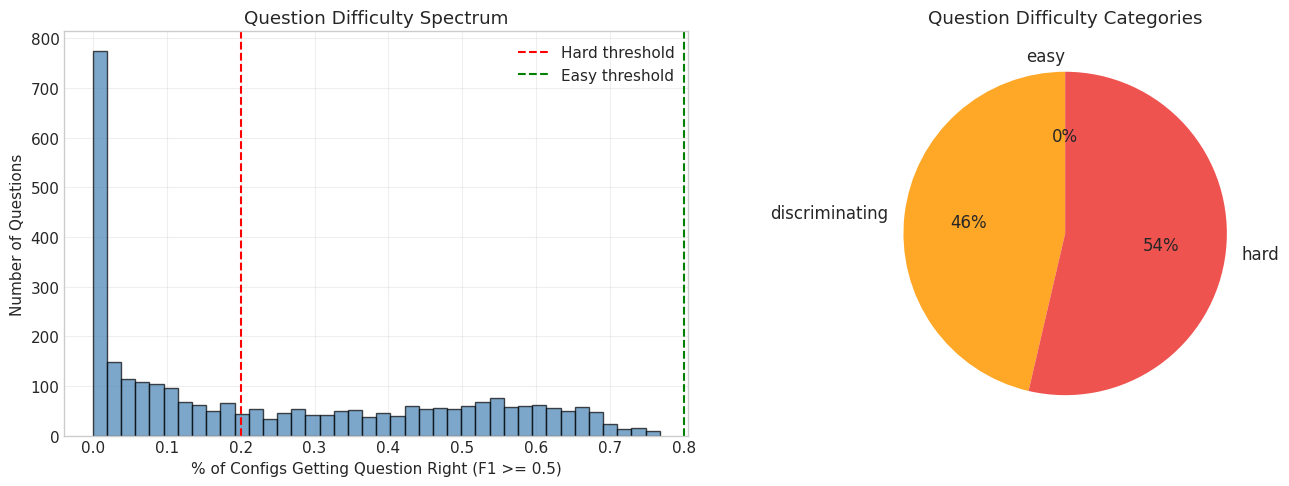

In [3]:
difficulty = compute_question_difficulty(item_scores, PRIMARY_METRIC, threshold=0.5)
print(f"Questions analyzed: {len(difficulty)}")

if not difficulty.empty:
    diff_counts = difficulty['difficulty'].value_counts()
    print(f"\nDifficulty distribution:")
    for cat in ['easy', 'discriminating', 'hard']:
        n = diff_counts.get(cat, 0)
        pct = n / len(difficulty) * 100
        print(f"  {cat:<15s}: {n:>4d} ({pct:.1f}%)")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram of pct_correct
    axes[0].hist(difficulty['pct_correct'], bins=40, color='steelblue',
                 alpha=0.7, edgecolor='black')
    axes[0].axvline(x=0.2, color='red', linestyle='--', label='Hard threshold')
    axes[0].axvline(x=0.8, color='green', linestyle='--', label='Easy threshold')
    axes[0].set_xlabel('% of Configs Getting Question Right (F1 >= 0.5)')
    axes[0].set_ylabel('Number of Questions')
    axes[0].set_title('Question Difficulty Spectrum')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Pie chart of difficulty categories
    colors = {'easy': '#66bb6a', 'discriminating': '#ffa726', 'hard': '#ef5350'}
    cats = ['easy', 'discriminating', 'hard']
    sizes = [diff_counts.get(c, 0) for c in cats]
    axes[1].pie(sizes, labels=cats, colors=[colors[c] for c in cats],
               autopct='%1.0f%%', startangle=90, textprops={'fontsize': 12})
    axes[1].set_title('Question Difficulty Categories')

    plt.tight_layout()
    plt.show()

Difficulty distribution by dataset:


difficulty,easy,discriminating,hard
dataset,,,
hotpotqa,0,29.0,71.0
nq,0,42.1,57.9
triviaqa,0,68.0,32.0


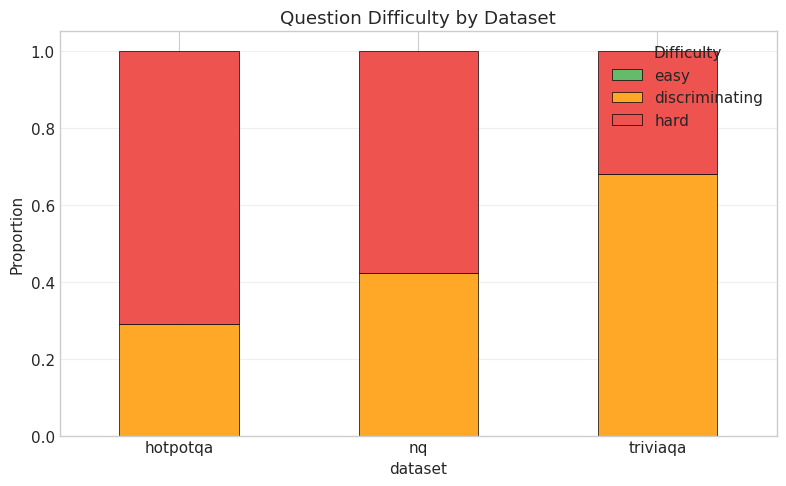

In [4]:
# Difficulty by dataset
if 'dataset' in difficulty.columns and not difficulty.empty:
    ds_diff = difficulty.groupby('dataset')['difficulty'].value_counts(normalize=True).unstack(fill_value=0)
    # Reorder columns
    for col in ['easy', 'discriminating', 'hard']:
        if col not in ds_diff.columns:
            ds_diff[col] = 0
    ds_diff = ds_diff[['easy', 'discriminating', 'hard']]

    print("Difficulty distribution by dataset:")
    display((ds_diff * 100).round(1))

    ds_diff.plot(kind='bar', stacked=True,
                color=['#66bb6a', '#ffa726', '#ef5350'],
                figsize=(8, 5), edgecolor='black', linewidth=0.5)
    plt.ylabel('Proportion')
    plt.title('Question Difficulty by Dataset')
    plt.legend(title='Difficulty')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 2. Error Taxonomy

Classify wrong answers into categories using heuristics.

Error Taxonomy (all predictions):
  wrong_answer        : 265439 (28.0%)
  correct             : 232786 (24.6%)
  partial_match       : 231322 (24.4%)
  over_verbose        : 122287 (12.9%)
  refusal/empty       :  89032 (9.4%)
  refusal/hedging     :   7134 (0.8%)

Error distribution by experiment type:


error_type,correct,over_verbose,partial_match,refusal/empty,refusal/hedging,wrong_answer
exp_type,,,,,,
direct,23.2,11.4,20.6,10.7,0.7,33.4
rag,24.6,13.0,24.6,9.3,0.8,27.7


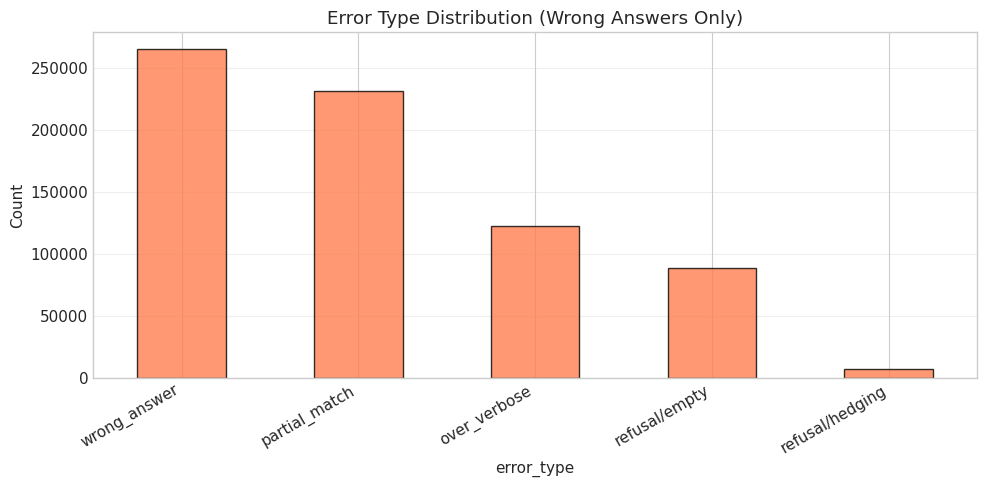

In [5]:
def classify_error(prediction: str, expected: list, f1_score: float) -> str:
    """Classify a wrong answer into an error category."""
    pred = str(prediction).strip().lower()

    if f1_score >= 0.5:
        return 'correct'

    if not pred or pred in ('', 'n/a', 'none', 'unknown'):
        return 'refusal/empty'

    # Check for hedging / "I don't know" patterns
    hedging_phrases = ['i don\'t know', 'i\'m not sure', 'cannot determine',
                       'not enough information', 'i am not sure', 'unclear',
                       'i cannot', 'unable to']
    if any(phrase in pred for phrase in hedging_phrases):
        return 'refusal/hedging'

    # Partial match: some token overlap
    if f1_score > 0.0:
        return 'partial_match'

    # Over-verbose: answer is very long (>200 chars)
    if len(pred) > 200:
        return 'over_verbose'

    return 'wrong_answer'


if 'prediction' in item_scores.columns and not item_scores.empty:
    # Classify errors
    item_scores['error_type'] = item_scores.apply(
        lambda r: classify_error(r.get('prediction', ''), r.get('expected', []), r[PRIMARY_METRIC]),
        axis=1
    )

    error_counts = item_scores['error_type'].value_counts()
    print("Error Taxonomy (all predictions):")
    print("=" * 50)
    for cat, count in error_counts.items():
        pct = count / len(item_scores) * 100
        print(f"  {cat:<20s}: {count:>6d} ({pct:.1f}%)")

    # Error type distribution by exp_type
    error_by_type = pd.crosstab(item_scores['exp_type'], item_scores['error_type'], normalize='index')
    print("\nError distribution by experiment type:")
    display((error_by_type * 100).round(1))

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    wrong_only = error_counts.drop('correct', errors='ignore')
    wrong_only.plot(kind='bar', ax=ax, color='coral', alpha=0.8, edgecolor='black')
    ax.set_ylabel('Count')
    ax.set_title('Error Type Distribution (Wrong Answers Only)')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

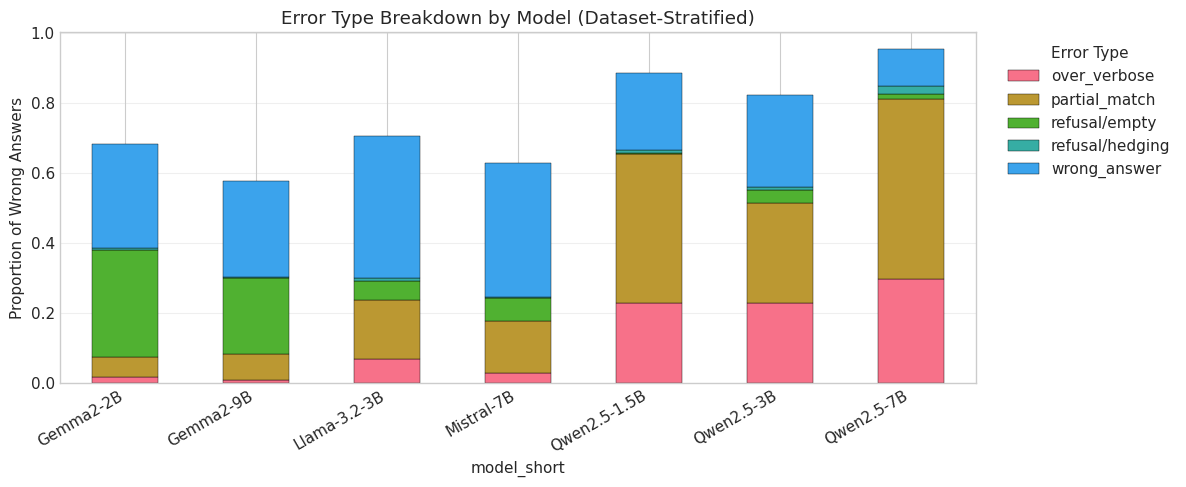

In [6]:
# Error types by model (dataset-stratified)
if 'error_type' in item_scores.columns:
    # Stratified: per-(model, dataset) error proportions, then average across datasets
    if 'dataset' in item_scores.columns and item_scores['dataset'].nunique() > 1:
        per_ds = (
            item_scores.groupby(['model_short', 'dataset'])['error_type']
            .value_counts(normalize=True)
            .rename('prop')
            .reset_index()
        )
        error_by_model = (
            per_ds.groupby(['model_short', 'error_type'])['prop']
            .mean()
            .unstack(fill_value=0)
        )
    else:
        error_by_model = pd.crosstab(item_scores['model_short'], item_scores['error_type'],
                                      normalize='index')

    # Drop correct for better visualization
    if 'correct' in error_by_model.columns:
        error_by_model = error_by_model.drop(columns='correct')

    fig, ax = plt.subplots(figsize=(12, 5))
    error_by_model.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', linewidth=0.3)
    ax.set_ylabel('Proportion of Wrong Answers')
    ax.set_title('Error Type Breakdown by Model (Dataset-Stratified)')
    ax.legend(title='Error Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

## 3. Answer Length Analysis

Answer length by experiment type:


,mean,median,std
exp_type,,,
direct,31.3,2.0,56.1
rag,42.5,3.0,66.6


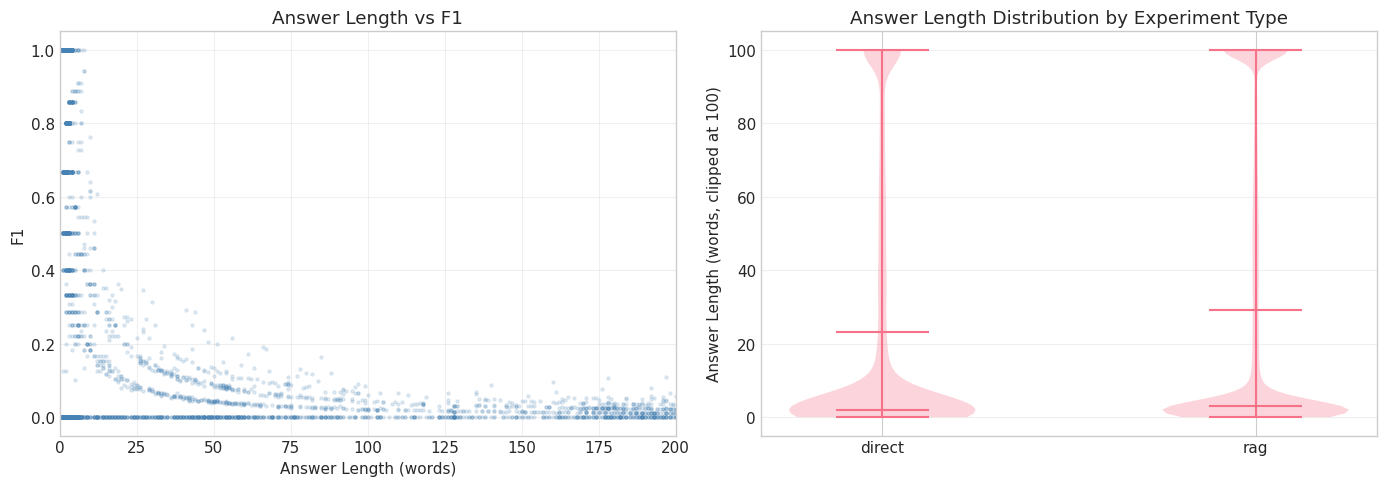

In [7]:
if 'prediction' in item_scores.columns:
    item_scores['answer_len'] = item_scores['prediction'].astype(str).str.len()
    item_scores['answer_words'] = item_scores['prediction'].astype(str).str.split().str.len()

    # Length vs F1 scatter
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sample for scatter (too many points otherwise)
    sample = item_scores.sample(min(5000, len(item_scores)), random_state=42)

    axes[0].scatter(sample['answer_words'], sample[PRIMARY_METRIC],
                    s=5, alpha=0.15, color='steelblue')
    axes[0].set_xlabel('Answer Length (words)')
    axes[0].set_ylabel('F1')
    axes[0].set_title('Answer Length vs F1')
    axes[0].set_xlim(0, min(200, sample['answer_words'].quantile(0.99)))
    axes[0].grid(alpha=0.3)

    # Mean length by exp_type
    len_by_type = item_scores.groupby('exp_type')['answer_words'].agg(['mean', 'median', 'std'])
    print("Answer length by experiment type:")
    display(len_by_type.round(1))

    # Violin: answer length by exp_type
    types = sorted(item_scores['exp_type'].unique())
    data_violin = [item_scores[item_scores['exp_type'] == t]['answer_words'].clip(upper=100).values
                   for t in types]
    parts = axes[1].violinplot(data_violin, showmeans=True, showmedians=True)
    axes[1].set_xticks(range(1, len(types) + 1))
    axes[1].set_xticklabels(types)
    axes[1].set_ylabel('Answer Length (words, clipped at 100)')
    axes[1].set_title('Answer Length Distribution by Experiment Type')
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [8]:
# Length by model
if 'answer_words' in item_scores.columns:
    len_by_model = item_scores.groupby('model_short')['answer_words'].agg(['mean', 'median'])
    len_by_model = len_by_model.sort_values('mean', ascending=False)
    print("Mean answer length by model (words):")
    display(len_by_model.round(1))

    # Correlation: answer length vs F1 per model
    print("\nCorrelation between answer length and F1 (per model):")
    for model in sorted(item_scores['model_short'].unique()):
        sub = item_scores[item_scores['model_short'] == model].dropna(subset=['answer_words', PRIMARY_METRIC])
        if len(sub) >= 10:
            from scipy.stats import spearmanr
            rho, pval = spearmanr(sub['answer_words'], sub[PRIMARY_METRIC])
            print(f"  {model:<18s}: rho={rho:+.3f}, p={pval:.2e}")

Mean answer length by model (words):


,mean,median
model_short,,
Qwen2.5-7B,101.0,93.0
Qwen2.5-1.5B,83.2,48.0
Qwen2.5-3B,50.9,23.0
Llama-3.2-3B,28.2,2.0
Mistral-7B,11.5,2.0
Gemma2-2B,5.2,1.0
Gemma2-9B,5.2,1.0



Correlation between answer length and F1 (per model):
  Gemma2-2B         : rho=+0.273, p=0.00e+00
  Gemma2-9B         : rho=+0.183, p=0.00e+00
  Llama-3.2-3B      : rho=+0.110, p=0.00e+00
  Mistral-7B        : rho=-0.105, p=0.00e+00
  Qwen2.5-1.5B      : rho=-0.186, p=0.00e+00
  Qwen2.5-3B        : rho=-0.114, p=0.00e+00
  Qwen2.5-7B        : rho=-0.194, p=0.00e+00


## 4. Model Agreement

Do different models agree on which questions are hard? High agreement suggests question-intrinsic difficulty; low agreement suggests model-specific weaknesses.

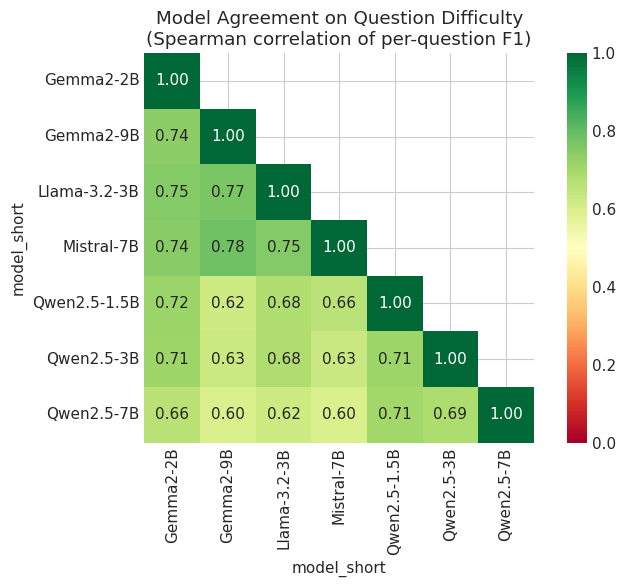


Mean inter-model correlation: 0.688
High = questions are intrinsically easy/hard
Low = difficulty is model-specific


In [9]:
# Per-model question difficulty (using best config per model)
if not item_scores.empty:
    # For each (model, idx, dataset), take the best F1 across all configs
    best_per_model = item_scores.groupby(
        ['model_short', 'idx', 'dataset']
    )[PRIMARY_METRIC].max().reset_index()

    # Pivot: rows=questions, columns=models, values=best F1
    pivot = best_per_model.pivot_table(
        index=['idx', 'dataset'], columns='model_short',
        values=PRIMARY_METRIC, aggfunc='max'
    )

    # Model-model correlation of per-question scores
    model_corr = pivot.corr(method='spearman')

    fig, ax = plt.subplots(figsize=(8, 6))
    mask = np.triu(np.ones_like(model_corr, dtype=bool), k=1)
    sns.heatmap(model_corr, annot=True, fmt='.2f', cmap='RdYlGn',
                vmin=0, vmax=1, mask=mask, ax=ax, square=True)
    ax.set_title('Model Agreement on Question Difficulty\n(Spearman correlation of per-question F1)')
    plt.tight_layout()
    plt.show()

    mean_corr = model_corr.where(~np.eye(len(model_corr), dtype=bool)).mean().mean()
    print(f"\nMean inter-model correlation: {mean_corr:.3f}")
    print("High = questions are intrinsically easy/hard")
    print("Low = difficulty is model-specific")

## 5. Sample Wrong Answers

Manually inspect a few wrong answers for qualitative insight.

In [10]:
# Sample discriminating questions (where some configs get it right, others don't)
if not difficulty.empty:
    disc = difficulty[difficulty['difficulty'] == 'discriminating'].sample(
        min(5, len(difficulty[difficulty['difficulty'] == 'discriminating'])),
        random_state=42
    )

    print("Sample Discriminating Questions:")
    print("=" * 80)
    for _, q in disc.iterrows():
        q_rows = item_scores[
            (item_scores['idx'] == q['idx'])
            & (item_scores.get('dataset', '') == q.get('dataset', ''))
        ]
        if q_rows.empty:
            continue

        q_text = q_rows['question'].iloc[0] if 'question' in q_rows.columns else 'N/A'
        expected = q_rows['expected'].iloc[0] if 'expected' in q_rows.columns else 'N/A'

        print(f"\nQ{q['idx']} [{q.get('dataset', 'N/A')}]: {str(q_text)[:150]}")
        print(f"  Expected: {expected}")
        print(f"  Correct in {q['pct_correct']*100:.0f}% of configs (n={q['n_configs']})")

        # Show a correct and incorrect answer
        correct = q_rows[q_rows[PRIMARY_METRIC] >= 0.5].head(1)
        incorrect = q_rows[q_rows[PRIMARY_METRIC] < 0.1].head(1)
        if not correct.empty:
            print(f"  Correct answer:   {str(correct['prediction'].iloc[0])[:150]}")
        if not incorrect.empty:
            print(f"  Incorrect answer: {str(incorrect['prediction'].iloc[0])[:150]}")

Sample Discriminating Questions:

Q921 [nq]: what type of boundary was the mexico earthquake
  Expected: ['a subduction zone']
  Correct in 26% of configs (n=307)
  Correct answer:    Cocos Plate subduction zone.
  Incorrect answer:  
1. From Passage 12, we learn that the 2011 Tohoku earthquake occurred in the Aleutian subduction zone.
2. From Passage 22, we learn that the 1985 Me

Q581 [triviaqa]: Which 2004 "puppet" movie, made by the makers of South Park, satirises Americas politics and jingoism?
  Expected: ['America fuck yeah', 'Dirka', 'America world police', 'Chris (Team America)', 'America, F**k Yeah', 'America, F**k Yeah!', 'America, Fuck Yeah (Bummer Remix)', 'Dirkastan', 'TAWP', 'Derka derka', 'America Fuck Yeah', 'Derkaderkistan', 'Derka', 'America, Fuck Yeah', 'America, Fuck Yeah!', 'Team America: World Police', 'Team america world police', 'Durkadurkastan', 'Team America World Police', 'Ronery', 'Team America: World Police (film)', 'America - Fuck Yeah!', 'Durkadurkistan'

## 6. Summary

Key findings:
- Question difficulty distribution and dataset differences
- Dominant error types and model-specific patterns
- Whether answer verbosity correlates with quality
- Degree of model agreement on question difficulty